In [1]:
%pylab tk

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import ndimage
from skimage.morphology import watershed, closing, square, disk, reconstruction, binary_closing, erosion
from skimage.segmentation import mark_boundaries, join_segmentations, relabel_sequential, slic, felzenszwalb, random_walker
from skimage.feature import peak_local_max, corner_peaks, canny
from skimage.io import imread
from skimage.filters import gaussian_filter, threshold_otsu, threshold_isodata, threshold_adaptive, threshold_yen, sobel
from skimage.exposure import adjust_log, adjust_sigmoid, adjust_gamma, equalize_hist, equalize_adapthist, rescale_intensity
from skimage.measure import regionprops, label
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import hough_circle
from skimage.filters.rank import entropy, mean_bilateral, gradient
from skimage.restoration import denoise_bilateral
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from skimage.draw import line, set_color
import time
import pickle

from matplotlib.cbook import CallbackRegistry
from IPython import display
from scipy import stats

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler

In [3]:
def scatter_plot(x, y, xlabel='', ylabel='', xlim=None, ylim=None, colors = None, alpha=1, s=10):
    clf()
    if xlim is None: x1,x2 = x.min(), x.max()*1.1
    else: x1,x2 = xlim[0], xlim[1]
        
    if ylim is None: y1,y2 = y.min(), y.max()*1.1
    else: y1,y2 = ylim[0], ylim[1]
        
    nullfmt   = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left+width+0.02
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    # start with a rectangular Figure
    plt.figure(1, figsize=(8,8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    if colors is None: axScatter.scatter(x, y, alpha=alpha)
    else: axScatter.scatter(x, y, c=colors, alpha=alpha, linewidths=0.0, s=s)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
    lim = ( int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim( (x1, x2) )
    axScatter.set_ylim( (y1, y2) )

    bins = 50
    axHistx.hist(x, bins=bins, range=(x1,x2))
    axHisty.hist(y, bins=bins, orientation='horizontal', range=(y1,y2))
    axHistx.set_xlim( axScatter.get_xlim() )
    axHisty.set_ylim( axScatter.get_ylim() )
    axScatter.set_xlabel(xlabel)
    axScatter.set_ylabel(ylabel)
    draw()
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def point_in_poly(x,y,poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

In [4]:
class ImageCounter:
    '''a class to train and apply counting on images'''
    def __init__(self, images, watershed = True):
        self.training_labels = []
        self.training_images = images
        self.training_description = self.describe(self.training_images)
        self.training_dimensions = (self.training_images[0][0].shape[0], self.training_images[0][0].shape[1])
        self.cls = None
        self.training = None
        self.classifications = None
        self.watershed = watershed
    
    ############
    def shadow_finder(self, image, g=2):
        seed = copy(image)
        seed[1:-1, 1:-1] = image.max()
        diff = reconstruction(seed, image, method='erosion')-image
        binary = diff>0
        res = label(binary)
        res[where(res>0)] = 1
        res = res - binary
        return gaussian_filter(res.astype(float32), g)
    
    def peak_finder_set(self, image, start=0, stop=7):
        seed = copy(image)
        seed[1:-1, 1:-1] = image.min()
        diff = image-reconstruction(seed, image, method='dilation')
        return [gaussian_filter(diff, i) for i in range(0,7,1)]
    
    def valley_finder(self, image, start=0, stop=1):
        seed = np.copy(image)
        seed[1:-1, 1:-1] = image.max()
        return reconstruction(seed, image, method='erosion')-image
    
    def dog_set(self, image, start, stop):
        return [equalize_adapthist(gaussian_filter(image, i) - gaussian_filter(image, i+1)) for i in range(start, stop)]
    ##############
    
    def describe(self, images):
        self.training_labels=[]
        des = []
        
        for image, typ in images:
            image = rgb2gray(image)
            if typ == 'fl':
                image = denoise_bilateral(image)
                image = equalize_adapthist(image)
                
                des = des + [image, sobel(image)]
                self.training_labels = self.training_labels + ['fluor', 'flsobel']
                
                des = des + self.dog_set(image, 1, 6)
                self.training_labels = self.training_labels +['fldog%d'%(i) for i in range(1,6)]

            elif typ == 'bf':
                res = self.shadow_finder(image)
                
                image = equalize_adapthist(image)
                image = denoise_bilateral(image)
                image = mean_bilateral(image, disk(10))
                
                des = des + self.peak_finder_set(image, 0, 7)
                self.training_labels = self.training_labels + ['peak rec %d'%(i) for i in range(0,7,1)]

                des = des + [sobel(image), res]
                self.training_labels = self.training_labels + ['sobel', 'valley']

                im_gaussian = [gaussian_filter(image, i) for i in range(0,7,1)]
                self.training_labels = self.training_labels + ['gauss %d'%(i) for i in range(0,7,1)]
                des = des + im_gaussian

                des = des + [self.valley_finder(a) for a in im_gaussian[0:1]]
                self.training_labels.append('valleys')

                des = des + self.dog_set(image, 1, 9)
                self.training_labels = self.training_labels + ['dog %d'%(i) for i in arange(1,9,1)]
            
        des = array(des)
        descriptors = des.reshape(des.shape[0],-1).transpose()
        return descriptors
    
    def get_imdex(self, x, y, dims):
        return int(y*dims[1] + x)
    
    def train(self, keys, classifications):
        training = [self.training_description[self.get_imdex(j[1], j[0], self.training_dimensions)] for j in keys]
        self.training = training
        self.classifications = classifications
        self.cls = RandomForestClassifier(n_jobs=-1, n_estimators=50)#KNeighborsClassifier()##svm.SVC(probability=True)
        self.cls.fit(training, classifications)
        
    def retrain(self):
        self.cls.fit(self.training, self.classifications)
        
    def get_cls(self):
        return self.cls
    
    def set_cls(self, s):
        self.cls = s
        
    def training_predict(self):
        if self.cls is None: return
        linear_prediction = self.cls.predict_proba(self.training_description)
        return linear_prediction[:,0].reshape((self.training_images[0][0].shape[0], self.training_images[0][0].shape[1]))
    
    def training_segment(self):
        if self.cls is None: return
        linear_prediction = self.cls.predict(self.training_description)
        prediction = linear_prediction.reshape((self.training_images[0][0].shape[0], self.training_images[0][0].shape[1]))
    
        if not self.watershed: return ndimage.label(prediction)[0], prediction
        else: return self.perform_watershed(prediction)
   
    def segment(self, images):
        if self.cls is None: return
        linear_prediction = self.cls.predict(self.describe(images))
        prediction = linear_prediction.reshape((images[0][0].shape[0], images[0][0].shape[1]))
    
        if not self.watershed: return ndimage.label(prediction)[0], prediction
        else: return self.perform_watershed(prediction)
        
    def perform_watershed(self, prediction, gf = 1, disksize = 4):
        sel1 = prediction.copy()
        sel2 = prediction.copy()
        sel3 = prediction.copy()
        
        #centers
        sel1[prediction < 3] = 0
        sel1[prediction == 3] = 1
        
        #centers and borders
        sel3[prediction<2] = 0
        sel3[prediction>=2] = 1
        
        #just borders
        sel2[sel2<3] = 0
        sel2[sel2>0] = 1
        
        dt = ndimage.distance_transform_edt(sel2)
        dt = gaussian_filter(dt, gf)
        dt = dt + (random.rand(dt.shape[0], dt.shape[1]) / (100.0*dt.max()))

        local_maxi = peak_local_max(dt, indices=False, footprint=disk(disksize), exclude_border=False)
        markers = ndimage.label(local_maxi)[0]
        labels = relabel_sequential(watershed(-dt, markers, mask=sel3))[0]
        
        centers = where(prediction == 3)
        centerlabels = ndimage.label(sel1)
        center_label_reduced = centerlabels[0][centers]
        labels_reduced = labels[centers]

        overmalap = vstack((center_label_reduced, labels_reduced)).transpose()
        centerlaps = {}

        for center_val, label_val in overmalap:
            if center_val not in centerlaps:
                centerlaps[center_val] = []
            if label_val not in centerlaps[center_val]:
                centerlaps[center_val].append(label_val)

        for k, v in centerlaps.iteritems():
            if len(v) > 1:
                firstval = v[0]
                for val in v[1:]:
                    labels[labels == val] = firstval
        labels=relabel_sequential(labels)[0]
        
        return labels, prediction


    
    def predict(self, images):
        if self.cls is None: return
        linear_prediction = self.cls.predict_proba(self.describe(images))
        return linear_prediction[:,0].reshape((images[0][0].shape[0], images[0][0].shape[1]))
    
    def count(self, image, flimage=None):
        r = 3
        a, b = r, r
        n = 2*a+1
        y,x = np.ogrid[-a:n-a, -b:n-b]
        mask = x*x + y*y <= r*r
        prediction = self.predict(image, flimage=flimage)
        prediction = gaussian_filter(prediction, 1)
        local_maxi = peak_local_max(prediction, indices=False, exclude_border=False, footprint=mask)
        markers = ndimage.label(local_maxi)[0]
        return markers.max()
    
        '''labs = label(results)
        a=regionprops(labs)
        for b in a:
            sli=b.image.astype(int8)
            c=b.bbox
            padsize=3
            pad = zeros((sli.shape[0]+padsize*2, sli.shape[1]+padsize*2))
            pad[padsize:-padsize, padsize:-padsize] = sli
            pad=binary_closing(pad, square(3))
            labs[c[0]:c[2], c[1]:c[3]][where(pad[padsize:-padsize, padsize:-padsize]>0)] = 1
        results = labs'''

class CellClassifier:
    """
    class to classify kinds of cells
    """
    def __init__(self, image):
        self.cls = None
        self.spreds = None
        self.image = image
        self.segmented=None
        self.repropped = False
        self.scaler = None
    
    def train(self, keys, classes):
        if not self.repropped: self.reprop()
        self.scaler = StandardScaler()
        self.cls=svm.SVC(kernel='poly', degree=4)
        properties = [self.spreds[i-1] for i in keys]
        
        self.scaler.fit(self.spreds)
        self.cls.fit(self.scaler.transform(properties), classes)
    
    def training_predict(self):
        if self.cls is None: return None
        return self.cls.predict(self.scaler.transform(self.spreds))
    
    def predict(self, segmentation):
        if self.cls is None: return None
        return self.cls.predict(self.scaler.transform(self.get_spreds(segmentation)))
    
    def reprop(self):
        if self.segmented is not None:
            self.spreds = self.get_spreds(self.segmented)
        self.repropped = True
    
    def get_spreds(self, segmentation, image=None):
        if image is None: image=self.image
        #tcprops = regionprops(labeled, rgb2gray(imtc))
        #ctrprops = regionprops(labeled, rgb2gray(imctr))
        full_props = array([[a.mean_intensity, \
                     a.area, a.perimeter, a.solidity, a.eccentricity,\
                     a.major_axis_length, a.minor_axis_length, a.convex_area, a.equivalent_diameter,\
                     ] for i,a in enumerate(regionprops(segmentation, rgb2gray(image)))])
        return full_props
    
    def update_segmented(self, segmentation):
        self.segmented = segmentation
        self.repropped=False
        
    def get_labeled_image(self, segmentation, prediction_results):
        zmat = zeros(segmentation.shape)
        for c in set(prediction_results):
            indices = array(range(0, len(prediction_results)+1))[where(prediction_results==c)]
            ix = in1d(segmentation.ravel(), indices+1).reshape(segmentation.shape)
            zmat[ix] = c
        return zmat
    
    
class ImageSelector:
    def __init__(self, fig1, fig2, counter, classifier, image=None):
        #figure things out with figures
        self.fig1=fig1
        fig1.clf()
        self.fig2 = fig2
        fig2.clf()
        self.ax1 = fig1.add_subplot(121) 
        self.ax2 = fig1.add_subplot(122, sharex=self.ax1, sharey=self.ax1)
        self.ax3 = fig2.add_subplot(211)
        self.ax4 = fig2.add_subplot(212)
        
        self.counter = counter
        if image is not None: self.image = image
        else: self.image = counter.training_images[0][0]
        self.segmented = None
        self.classified_image = None
        
        #data structures for classification
        self.classifier = classifier
        self.class_pts = []
        self.cell_classes = []
        self.cell_class_pts = self.ax2.scatter([], [], c=[])
        
        #connect events
        self.fig1.canvas.mpl_connect("key_press_event", self.key)
        self.fig1.canvas.mpl_connect('button_press_event', self.button)
        
        self.vertices = []
        self.mode = 'cell'
        self.image_shape = (self.image.shape[0], self.image.shape[1])
        self.mask = zeros(self.image_shape)
        self.ax1.set_title(self.mode)
        self.path, = self.ax1.plot([],[],'o-',lw=3)
        
        #show the images
        self.cell_image = self.ax1.imshow(label2rgb(self.mask, self.image, bg_label=0), interpolation='nearest')
        self.seg_image = self.ax2.imshow(self.image, interpolation='nearest')
        
        self.draw()
        
    def draw(self):
        self.fig2.canvas.draw()
        self.fig1.canvas.draw()
        
        
    def showax1(self):
        self.cell_image.set_data(label2rgb(self.mask, self.image, bg_label=0, alpha=0.2))
        self.draw()
        
    def showax2(self, im):
        self.seg_image.set_data(mark_boundaries(label2rgb(im[1], self.image, bg_label=1), im[0], color=(1,1,1)))
        self.draw()
        
    def showax2_class_results(self):
        self.seg_image.set_data(label2rgb(self.classified_image, self.image, bg_label=1))
        self.draw()
        
    def key(self, event):
        if is_number(event.key) and event.inaxes:
            try:
                x,y = int(round(event.xdata)), int(round(event.ydata))
                self.class_pts.append((x,y))
                self.cell_classes.append(int(event.key))
                self.update_lines()
            except:
                print 'woops'
        elif event.key == 'u' and self.mode != 'classify':
            self.train_segmenter()
            return
        elif event.key == 'u' and self.mode == 'classify':
            self.train_classifier()
            self.fig1.waiting=False
            self.fig2.waiting=False
        elif event.key==' ': 
            self.mode = 'cell'
        elif event.key=='b': 
            self.mode = 'background'           
        elif event.key=='i':
            self.mode = 'classify'
        self.ax1.set_title(self.mode)
        self.draw()
    
    def button(self, event):
        if not event.inaxes or plt.get_current_fig_manager().toolbar.mode != '': return
        
        if self.mode in ['cell', 'background']:
            if event.button == 1:
                x,y = int(round(event.xdata)), int(round(event.ydata))
                self.vertices.append((x,y))
                self.update_lines()
            if event.button==2:
                if len(self.vertices) > 0: 
                    self.vertices.pop()
                    self.update_lines()
            if event.button==3:
                if len(self.vertices) > 0:
                    if self.mode=='cell': self.vertices.append(self.vertices[0])
                    self.update_mask()
        elif self.mode == 'classify':
            if event.button == 1:
                if len(self.class_pts) > 0 and len(self.cell_classes) > 0:
                    self.class_pts.pop()
                    self.cell_classes.pop()
                    self.update_lines()
            if event.button==2:
                pass
            if event.button==3:
                if self.segmented is None: return
                pass
            
    def update_lines(self):
        x = [i[0] for i in self.vertices]
        y = [i[1] for i in self.vertices]
        self.path.set_data(x,y)
        
        self.cell_class_pts.set_offsets(self.class_pts)
        self.cell_class_pts.set_facecolors([rcParams['axes.color_cycle'][i] for i in k.cell_classes])
        
        self.draw()
        
    def update_mask(self):
        marker_color = 1
        
        if self.mode == 'cell':
            marker_color = 2
            vlist = array(self.vertices)
            xmin, xmax, ymin, ymax = vlist[:,0].min(), vlist[:,0].max(), vlist[:,1].min(), vlist[:,1].max()
            for x in range(xmin, xmax+1):
                for y in range(ymin, ymax+1):
                    if point_in_poly(x, y, vlist):
                        self.mask[y,x]=3
        
        if len(self.vertices) > 1:
            for a,b in zip(self.vertices[:-1], self.vertices[1:]):
                set_color(self.mask, line(a[1], a[0], b[1], b[0]), marker_color)
        
        
            
        self.vertices = []
        self.showax1()
        
    def train_segmenter(self):
        points = argwhere(self.mask > 0).tolist()
        classifications = self.mask[self.mask > 0].tolist()
        self.counter.train(points, classifications)
        results = counter.training_segment()
        self.segmented = results[0]
        self.classifier.update_segmented(self.segmented)
        
        self.ax3.cla()
        self.ax3.plot(self.counter.cls.feature_importances_, 'o-')
        self.ax3.set_xticks(range(0,len(self.counter.training_labels)))
        self.ax3.set_xticklabels(self.counter.training_labels, rotation='vertical')
        self.ax3.grid()
        
        self.showax2(results)
        
    def train_classifier(self):
        keys, classes = [], []
        for point, classification in zip(self.class_pts, self.cell_classes):
            if self.segmented[point[1], point[0]] > 0:
                keys.append(self.segmented[point[1], point[0]])
                classes.append(classification)
        self.classifier.train(keys, classes)
        results = self.classifier.training_predict()
        self.classified_image = self.classifier.get_labeled_image(self.segmented, results)
        self.showax2_class_results()

def get_images(image, sel=1024):
    x,y,z=image.shape
    
    tl =image[:x/2,:y/2]
    tr =image[:x/2,y/2+1:]
    bl =image[x/2+1:,:y/2]
    br = image[x/2+1:,y/2+1:]
    
    if sel is not None: return tl[sel:, :sel], tr[sel:, :sel], br[sel:, :sel], bl[sel:, :sel]
    else: return tl, tr, br, bl

In [5]:
#path='/Users/richardkwant/Documents/Berkeley/rkwant/Notebook_Pages/Pages/5-099/'
path='C:\\Users\\rkwant\\Documents\\Berkeley\\rkwant\\Notebook_Pages\\Pages\\5-066\\'
classpath = 'C:\\Users\\rkwant\\Documents\\Berkeley\\rkwant\\Notebook_Pages\\Pages\\5-066\\'
fname='SAV1.tif'
image=imread(path+fname)

imtc, imctr, immerg, imbf = get_images(image, sel=1024)

counter = ImageCounter([(imbf, 'bf'), (imtc, 'fl'), (imctr, 'fl')])
classifier = CellClassifier(imbf)

C:\Users\rkwant\AppData\Local\Enthought\Canopy\User\lib\site-packages\skimage\util\dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
C:\Users\rkwant\AppData\Local\Enthought\Canopy\User\lib\site-packages\skimage\util\dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [6]:
f1=figure(1)
subplots_adjust(0, 0, 1, 0.96, 0, 0)
f2=figure(2)
k=ImageSelector(f1, f2, counter, classifier, image=immerg)

In [7]:
#save the results
countername = 'counter_20150522-5-066'
if True:
    counter.training_images=None
    counter.training=None
    counter.classifications=None
    counter.training_description=None
    with open(classpath+countername+'.pickle', 'wb') as f:
        pickle.dump(counter, f)
    with open(classpath+fname+'_mask.dat', 'wb') as f:
        save(f, k.mask)
else:
    with open(classpath+countername+'.pickle', 'rb') as f:
        counter = pickle.load(f)
    #with open(path+fname+'_mask.dat', 'rb') as f:
        #mask=load(f)

# Classification of segmentation

In [8]:
labeled,pred= counter.segment([(imbf, 'bf'), (imtc, 'fl'), (imctr, 'fl')])
results=labeled

In [9]:
class CellClassifier:
    def __init__(self, spreds):
        self.cls = None
        self.spreds = spreds
        self.scaler = StandardScaler()
        self.scaler.fit(self.spreds)
    
    def train(self, properties, classifications):
        self.cls=svm.SVC(kernel='poly', degree=4)
        self.cls.fit(properties, classifications)
    
    def predict(self, properties):
        if self.cls is None: return None
        return self.cls.predict(properties)
    
    def getprops(self, labeled, image1, image2):
        tcprops = regionprops(labeled, rgb2gray(image2))
        #ctrprops = regionprops(labeled, rgb2gray(imctr))
        full_props = array([[a.mean_intensity, tcprops[i].mean_intensity, \
                     a.area, a.perimeter, a.solidity, a.eccentricity,\
                     a.major_axis_length, a.minor_axis_length, a.convex_area, a.equivalent_diameter,\
                     ] for i,a in enumerate(regionprops(labeled, rgb2gray(image2)))])
        return full_props
    
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [10]:
tcprops = regionprops(labeled, rgb2gray(imtc))
#ctrprops = regionprops(labeled, rgb2gray(imctr))
full_props = array([[a.mean_intensity, tcprops[i].mean_intensity, \
                     a.area, a.perimeter, a.solidity, a.eccentricity,\
                     a.major_axis_length, a.minor_axis_length, a.convex_area, a.equivalent_diameter,\
                     ] for i,a in enumerate(regionprops(labeled, rgb2gray(imbf)))])

In [11]:
#figure 1 will show the image
fig = figure(1)
clf()
ax1 = subplot(1,2,1)
ax1.imshow(imbf, cmap='bone', interpolation='nearest')
ax2 = subplot(1,2,2, sharex=ax1, sharey=ax1)
ax2.imshow(results, cmap='bone') 
show()

#figure 2 will show counting results
fig2=figure(2)
ax3=subplot(1,1,1)
show()

properties = []
classifications = []

settings = None

cellclass = CellClassifier(full_props)
iteration = 0    
def onkey(event):
    global properties, classifications, cellclass, iteration
    settings = (ax1.get_xlim(), ax1.get_ylim())
    x,y = event.xdata, event.ydata
    try:
        

        if is_number(event.key):
            xf, yf = round(x), round(y)
            index = labeled[yf,xf]
            if index >= 0:
                properties.append(full_props[labeled[yf,xf]-1])
                classifications.append(int(event.key))
                ax1.plot(xf, yf, 'o', color=rcParams['axes.color_cycle'][int(event.key)])
                fig.canvas.draw()


        if len(classifications) > 2 and event.key == 'u':

            cellclass.train(properties, classifications)
            spreds = cellclass.predict(full_props)

            zmat = zeros(labeled.shape)
            for c in set(spreds):
                indices = array(range(0, len(spreds)+1))[where(spreds==c)]
                ix = in1d(labeled.ravel(), indices+1).reshape(labeled.shape)
                zmat[ix] = c


            for i in set(spreds):
                ax3.plot(iteration, len(spreds[spreds==i]), 'o', color=rcParams['axes.color_cycle'][i])
            iteration +=1

            image_label_overlay = label2rgb(zmat, image=imbf, bg_label = 0)
            marked = mark_boundaries(image_label_overlay, labeled, color=(1, 1, 1))
            ax2.cla()
            ax2.imshow(marked)
            ax1.set_xlim(settings[0])
            ax1.set_ylim(settings[1])

            fig.canvas.draw()
            fig2.canvas.draw()
    except:
        print 'woops'
        pass

pid = fig.canvas.mpl_connect("key_press_event", onkey)

show()

In [12]:
if True:
    f=open(classpath+'_shape_classifier_rkmb_20150522-5-066.pickle', 'wb')
    pickle.dump(cellclass, f)
    f.close()
else:
    with open(classpath+'_shape_classifier_rkmb_20150521-2.pickle', 'rb') as f:
        cellclass = pickle.load(f)

In [12]:
fname='BG11b.tif'
spreds = cellclass.predict(full_props)
counts = []
for i in set(spreds):
    counts.append(len(spreds[spreds==i]))
    print i, len(spreds[spreds==i])
print float(counts[1]) / (counts[1] + counts[0])

1 1197
2 302
3 53
0.201467645097


In [13]:
zmat = zeros(labeled.shape)
for c in set(spreds):
    indices = array(range(0, len(spreds)+1))[where(spreds==c)]
    ix = in1d(labeled.ravel(), indices+1).reshape(labeled.shape)
    zmat[ix] = c

image_label_overlay = label2rgb(zmat, image=imbf, bg_label = 0)
marked = mark_boundaries(image_label_overlay, labeled, color=(1, 1, 1))

figure(1, figsize=(10, 10))
clf()
imshow(marked)
show()

savefig(path+fname+'_classified.jpg', dpi=300)

#Determine quality of classification

In [24]:
fig = figure(1)
clf()
show(block=False)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = mean(a), stats.sem(a)
    h = stats.t.interval(confidence, n-1)[1]*std(a, ddof=1)/sqrt(n)
    return m, h

In [17]:
files = ['SAV1', 'SAV2', 'Burke1', 'Burke2']#['BG11b', 'BG11aa', 'BG11c', 'SAVa', 'SAVb', 'SAVc']
manual = {}
auto = {}
predictions = {}
images = {}
rprops = {}


for fname in files[:]:
    print fname
    
    if True:
        image=imread(path+fname+'.tif')
        imtc, imctr, immerg, imbf = get_images(image, sel=1024)
        segmentation = counter.segment([(imbf, 'bf'), (imtc, 'fl'), (imctr, 'fl')])[0]
        
        rprop = regionprops(segmentation, rgb2gray(imbf))

        tcprops = regionprops(segmentation, rgb2gray(imtc))
        #ctrprops = regionprops(labeled, rgb2gray(imctr))
        full_props = array([[a.mean_intensity, tcprops[i].mean_intensity, \
                             a.area, a.perimeter, a.solidity, a.eccentricity,\
                             a.major_axis_length, a.minor_axis_length, a.convex_area, a.equivalent_diameter,\
                             ] for i,a in enumerate(rprop)])

        predictions[fname] = cellclass.predict(full_props)
        images[fname] = immerg
        rprops[fname] = rprop

SAV1
SAV2
Burke1
Burke2


{'SAV2': array([87, 63,  0]), 'Burke2': array([64, 86,  0]), 'Burke1': array([71, 78,  0]), 'SAV1': array([75, 75,  0])}
{'SAV2': array([90, 60,  0]), 'Burke2': array([76, 74,  0]), 'Burke1': array([88, 61,  0]), 'SAV1': array([81, 69,  0])}


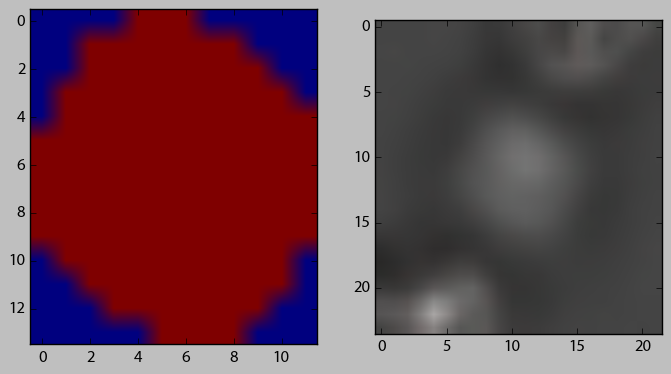

What is it?1
1


In [28]:
if False:
    manual = {}
    auto = {}

    for fname in files:
        manual[fname] = array([0,0,0])
        auto[fname] = array([0,0,0])

working = True
a = []
pad = 5

while working:
    display.clear_output(wait=True)
    print manual
    print auto
    
    if len(a)==0:
        a = ['SAV1', 'SAV2', 'Burke1', 'Burke2']#['BG11b', 'BG11aa', 'BG11c', 'SAVa', 'SAVb', 'SAVc']
        random.shuffle(a)
    fname = a.pop()
    index = int(floor(random.rand(1)*len(rprops[fname]))[0])

    clf()
    subplot(121)
    imshow(rprops[fname][index].image)
    subplot(122)
    bbox = rprops[fname][index].bbox
    imshow(images[fname][bbox[0]-pad:bbox[2]+pad, bbox[1]-pad:bbox[3]+pad])
    fig.canvas.draw()
    
    display.display(gcf())
    
    if predictions[fname][index] == 3: result = 111
    else: result = int(raw_input('What is it?'))
    print result
    if result==0: break
    if result > 2 or result < 1: a.append(fname)
    else:
        manual[fname][result-1] = manual[fname][result-1] + 1
        auto[fname][predictions[fname][index]-1] = auto[fname][predictions[fname][index]-1] + 1
    
    done = True
    for fname in files:
        done = manual[fname][0] + manual[fname][1] >= 150 and done
    working = not done

In [31]:
figure(1)
clf()

c1='black'
c2='#1B52BF'

mantot = array([0,0,0])
autotot = array([0,0,0])

a1 = subplot(211)


man1 = []
man2 = []
au1 = []
au2 = []

for f in files:
    man1.append(manual[f][0])
    man2.append(manual[f][1])
    au1.append(auto[f][0])
    au2.append(auto[f][1])
man1=array(man1)
man2=array(man2)
au1=array(au1)
au2=array(au2)

title('Counts for not dividing and dividing')
x = arange(0, len(files), 1)
w=0.15
a1.bar(x, man1, w, color=c1, label='manual')
a1.bar(x+0.4, man2, w, color=c1)

a1.bar(x+0.2, au1, w, color=c2, label='auto')
a1.bar(x+0.6, au2, w, color=c2)
legend()
ylim((0, 130))
xticks(x+0.5, files)

    
a2 = subplot(212)
title('Percent actively dividing')
mpercents = 1.0*man2 / (man1+man2)
apercents = 1.0*au2 / (au1+au2)

#Burke
m,e = mean_confidence_interval(mpercents[2:], 0.83)
a2.bar(0, m, yerr=e, color=c1, ecolor=c2)
m,e = mean_confidence_interval(apercents[2:], 0.83)
a2.bar(3, m, yerr=e, color=c1, ecolor=c2)

#SAV
m,e = mean_confidence_interval(mpercents[:2], 0.83)
a2.bar(1, m, yerr=e, color=c2, ecolor=c1)
m,e = mean_confidence_interval(apercents[:2], 0.83)
a2.bar(4, m, yerr=e, color=c2, ecolor=c1)

xticks([0.4, 1.4, 3.4, 4.4], ['Burke, Manual', 'SAV, Manual', 'Burke, Auto', 'SAV, Auto'])

([<matplotlib.axis.XTick at 0x1bd82748>,
 <a list of 4 Text xticklabel objects>)

In [113]:
mpercents

array([ 0.2254902 ,  0.23762376,  0.18627451,  0.1372549 ,  0.31      ,
        0.18811881])

# Chugging

In [14]:
hist_dict = {}
tc_hist_dict = {}
for fname in ['SAV1', 'SAV2', 'Burke1', 'Burke2']:#['BG11b', 'BG11aa', 'BG11c', 'SAVa', 'SAVb', 'SAVc']:    
    #print out images with counting ticks
    image=imread(path+fname+'.tif')
    imtc, imctr, immerg, imbf = get_images(image, sel=1024)

    results = counter.segment([(imbf, 'bf'), (imtc, 'fl'), (imctr, 'fl')])[0]
    labeled = results
    
    

    print 'done segmenting'

    tcprops = regionprops(labeled, rgb2gray(imtc))
    #ctrprops = regionprops(labeled, rgb2gray(imctr))
    full_props = array([[a.mean_intensity, tcprops[i].mean_intensity, \
                         a.area, a.perimeter, a.solidity, a.eccentricity,\
                         a.major_axis_length, a.minor_axis_length, a.convex_area, a.equivalent_diameter,\
                         ] for i,a in enumerate(regionprops(labeled, rgb2gray(imbf)))])

    spreds = cellclass.predict(full_props)

    print 'predicted classifications'

    counts = []
    for i in set(spreds):
        counts.append(len(spreds[spreds==i]))
        print i, len(spreds[spreds==i])
    print float(counts[1]) / (counts[1] + counts[0])

    zmat = zeros(labeled.shape)
    for c in set(spreds):
        indices = array(range(0, len(spreds)+1))[where(spreds==c)]
        ix = in1d(labeled.ravel(), indices+1).reshape(labeled.shape)
        zmat[ix] = c

    image_label_overlay = label2rgb(zmat, image=imbf, bg_label = 0)
    marked = mark_boundaries(image_label_overlay, labeled, color=(1, 1, 1))

    figure(2, figsize=(10, 10))
    clf()
    imshow(image_label_overlay)
    title('Normal: %d, Dividing: %d, %0.3f'%(counts[0], counts[1], float(counts[1]) / (counts[1] + counts[0])))
    show()

    savefig(path+fname+'_classified_20150522-3.jpg', dpi=300)
"""
    props_tc = regionprops(labeled, rgb2gray(imtc))
    props_ctr = regionprops(labeled, rgb2gray(imctr))
    tc_int = array([a.mean_intensity for a in props_tc])
    ctr_int = array([a.mean_intensity for a in props_ctr])

    selector = where(spreds<3)
    tc_int, ctr_int = tc_int[selector], ctr_int[selector]
    cvals = spreds[selector]

    figure(1)
    clf()
    scatter_plot(array(tc_int), array(ctr_int), \
                 xlabel='total cell', ylabel='cell tracker', \
                 xlim=(0, 0.08), ylim=(0, 0.8), colors=cvals, alpha=0.2, s=10)
    suptitle(fname)
    show()
    savefig(path+fname+'_rg_scatter.pdf')

    hist_dict[fname] = histogram(ctr_int, bins=50)
    tc_hist_dict[fname] = histogram(tc_int, bins=50)"""

done segmenting
predicted classifications
1 190
2 153
3 32
0.446064139942
done segmenting
predicted classifications
1 213
2 165
3 31
0.436507936508
done segmenting
predicted classifications
1 282
2 229
3 35
0.448140900196
done segmenting
predicted classifications
1 278
2 181
3 43
0.394335511983


"\n    props_tc = regionprops(labeled, rgb2gray(imtc))\n    props_ctr = regionprops(labeled, rgb2gray(imctr))\n    tc_int = array([a.mean_intensity for a in props_tc])\n    ctr_int = array([a.mean_intensity for a in props_ctr])\n\n    selector = where(spreds<3)\n    tc_int, ctr_int = tc_int[selector], ctr_int[selector]\n    cvals = spreds[selector]\n\n    figure(1)\n    clf()\n    scatter_plot(array(tc_int), array(ctr_int),                  xlabel='total cell', ylabel='cell tracker',                  xlim=(0, 0.08), ylim=(0, 0.8), colors=cvals, alpha=0.2, s=10)\n    suptitle(fname)\n    show()\n    savefig(path+fname+'_rg_scatter.pdf')\n\n    hist_dict[fname] = histogram(ctr_int, bins=50)\n    tc_hist_dict[fname] = histogram(tc_int, bins=50)"

In [153]:
figure(3)
clf()
ax1 = subplot(211)
ax2=subplot(212)
thedic = hist_dict


bres, sres = zeros(thedic[thedic.keys()[0]][0].shape), zeros(thedic[thedic.keys()[0]][0].shape)

for key in sorted(thedic.iterkeys()):
    val=thedic[key]
    x=array(zip(val[1][:-1], val[1][1:])).mean(axis=1)
    isBurke = key.find('Burke') > -1
    ax1.plot(x, val[0], color='Black' if isBurke else 'Red', label=key)
    
    if isBurke: bres+=val[0]
    else: sres+=val[0]
ax2.plot(x, bres/bres.sum(), 'Black', label='Burke')
ax2.plot(x, sres/sres.sum(), 'Red', label='SAV')

ax1.legend(ncol=3)
ax2.legend()

ax1.set_ylabel('Cell count')
ax2.set_ylabel('Summed Prob. Density')
ax2.set_xlabel('Cell tracker intensity')

savefig(path+'histograms.pdf')

In [27]:
bg=array([0.169, 0.128, 0.154])
sav=array([0.107, 0.139, 0.114])

95.333333333333329